In [1]:
import json

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import loader as L

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
batch_size = 32

In [3]:
filter = ['male', 'female']
# filter = ['male', 'female', 'cigarette']

train_dataset = L.PunksDataset(filter, train=True)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=False
)

test_dataset = L.PunksDataset(filter, train=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

In [4]:
# Explore Dataset
punk, labels = train_dataset[42]
print(punk.shape)
print(labels)
for f,l in zip(filter, labels):
    print(f"{f}: {l}")
L.write_image(punk, "output/42.jpg")


# Explore Loader
punk_batch, labels_batch = next(iter(train_loader))
print(type(punk_batch))
print(type(punk_batch[0]))
print(type(punk_batch[0][0]))
print(type(punk_batch[0][0][0]))
# print(type(punk_batch[0][0][0][0]))
print(punk_batch.shape)
print(punk_batch[0].shape)
print("filter:", labels_batch[0].numpy())


# Write new image with loaded data
L.write_image(punk_batch[0].numpy(), "output/0.jpg")

(24, 24, 4)
[0 1]
male: 0
female: 1
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 24, 24, 4])
torch.Size([24, 24, 4])
filter: [0 1]


In [5]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(24*24*4, 200),
    nn.ReLU(),
    nn.Linear(200, 150),
    nn.ReLU(),
    nn.Linear(150, len(filter)),
    nn.ReLU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

model.to(device)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=150, bias=True)
  (4): ReLU()
  (5): Linear(in_features=150, out_features=2, bias=True)
  (6): ReLU()
)

In [6]:
num_epoch = 10
training_loss = 0
test_loss = 0


for epoch in range(num_epoch):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.type(torch.float64))
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    print('====> Epoch[{}/{}], loss: {:.6f}'.format(
        epoch + 1, num_epoch, loss.data.item()
    ))

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels.type(torch.float64))

        test_loss /= len(test_loader.dataset)
        print('====> Test[{}/{}],  loss: {:.6f}'.format(
            epoch + 1, num_epoch, test_loss.data.item()
        ))


====> Epoch[1/10], loss: 0.003057
====> Test[1/10],  loss: 0.000096
====> Epoch[2/10], loss: 0.000463
====> Test[2/10],  loss: 0.000015
====> Epoch[3/10], loss: 0.000155
====> Test[3/10],  loss: 0.000005
====> Epoch[4/10], loss: 0.000074
====> Test[4/10],  loss: 0.000002
====> Epoch[5/10], loss: 0.000042
====> Test[5/10],  loss: 0.000001
====> Epoch[6/10], loss: 0.000025
====> Test[6/10],  loss: 0.000001
====> Epoch[7/10], loss: 0.000016
====> Test[7/10],  loss: 0.000001
====> Epoch[8/10], loss: 0.000010
====> Test[8/10],  loss: 0.000000
====> Epoch[9/10], loss: 0.000007
====> Test[9/10],  loss: 0.000000
====> Epoch[10/10], loss: 0.000005
====> Test[10/10],  loss: 0.000000


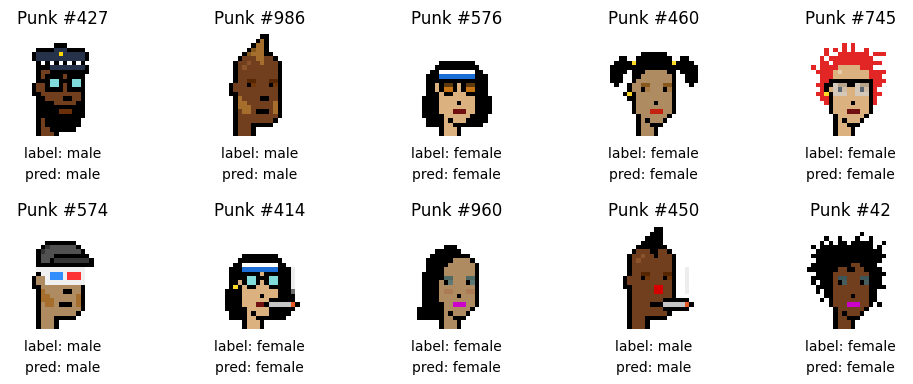

In [13]:
import random


fig, ax = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        idx = random.randint(0, len(test_dataset)-1)
        if i == 1 and j == 4: idx = 42
        img, label = test_dataset[idx]
        img_tensor = torch.Tensor([img]).to(device)

        ax[i,j].imshow(img)
        ax[i,j].set_title(f'Punk #{idx}')
        ax[i,j].axis('off')

        result = model(img_tensor)
        result = F.softmax(result, dim=-1)
        pred = "male" if result[0][0] > result[0][1] else "female"
        actual = "male" if label[0] > label[1] else "female"

        ax[i,j].text(
            0.5, -0.2, 
            f"label: {actual}", 
            fontsize=10, 
            ha='center',
            transform=ax[i,j].transAxes
        )
        ax[i,j].text(
            0.5, -0.4, 
            f"pred: {pred}", 
            fontsize=10, 
            ha='center',
            transform=ax[i,j].transAxes
        )


plt.tight_layout()
plt.show()
